In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.applications import VGG16 , EfficientNetB0 , ResNet50 , InceptionV3 , Xception , MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

# Define paths for Google Drive directories
train_dir = '/content/drive/MyDrive/TrainUpdate'
test_dir = '/content/drive/MyDrive/Test'






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import imgaug.augmenters as iaa

# إعداد ImageDataGenerator للتحويلات الأساسية
datagen = ImageDataGenerator(
    rotation_range=40,      # Random rotations in the range of 0 to 40 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2, # Random vertical shifts
    shear_range=0.2,        # Shear transformations
    zoom_range=0.5,         # Random zoom
    horizontal_flip=True,   # Random horizontal flips
    vertical_flip=True,     # Random vertical flips
    fill_mode='nearest',    # Strategy to fill newly created pixels
    brightness_range=[0.5, 1.5], # Randomly change brightness
    channel_shift_range=50, # Randomly shift color channels
)

# إعداد imgaug للتحويلات المتقدمة
seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(10, 60)), # إضافة ضوضاء غاوسية
    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)), # شحذ الصورة
    iaa.Multiply((0.8, 1.2)), # مضاعفة القيم اللونية
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # تصغير/تكبير
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # نقل
        rotate=(-25, 25), # تدوير
        shear=(-8, 8) # قص
    )
], random_order=True) # تطبيق التحويلات بترتيب عشوائي

# تحميل وتكبير صور التدريب
train_dataset = image_dataset_from_directory(train_dir, image_size=(224, 224), batch_size=20, label_mode='categorical')

augmented_train_images = []
augmented_train_labels = []

for images, labels in train_dataset:
    for i in range(len(images)):
        image = images[i].numpy()
        label = labels[i].numpy()

        # تطبيق ImageDataGenerator
        for _ in range(7):  # يمكنك ضبط العدد
            augmented_image = datagen.random_transform(image)
            augmented_train_images.append(augmented_image)
            augmented_train_labels.append(label)

        # تطبيق imgaug
        for _ in range(8):  # يمكنك ضبط العدد
            augmented_image = seq(image=image)
            augmented_train_images.append(augmented_image)
            augmented_train_labels.append(label)

augmented_train_images = tf.convert_to_tensor(augmented_train_images, dtype=tf.float32)
augmented_train_labels = tf.convert_to_tensor(augmented_train_labels, dtype=tf.float32)

# طباعة عدد الصور بعد التحسين
print(f"Number of images after augmentation: {len(augmented_train_images)}")


Found 260 files belonging to 30 classes.
Number of images after augmentation: 3900


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import Precision, Recall

# Define a custom F1-score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define the model architecture
model_scratch = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(30, activation='softmax')
])

# Compile the model with additional metrics
initial_learning_rate = 0.0001
model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), F1Score()])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Setup K-Fold Cross-Validation
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

overall_accuracy = []

for train_index, val_index in kf.split(augmented_train_images):
    # Gather subsets for the training and validation sets
    train_images = tf.gather(augmented_train_images, train_index)
    val_images = tf.gather(augmented_train_images, val_index)
    train_labels = tf.gather(augmented_train_labels, train_index)
    val_labels = tf.gather(augmented_train_labels, val_index)

    # Fit the model on the training data
    history = model_scratch.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=50,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model on the validation data
    results = model_scratch.evaluate(val_images, val_labels, verbose=1)
    overall_accuracy.append(results[1])
    print(f'Fold validation accuracy: {results[1]}')
    print(f'Fold validation precision: {results[2]}')
    print(f'Fold validation recall: {results[3]}')
    print(f'Fold validation F1-score: {results[4]}')

print(f'Average Validation Accuracy: {np.mean(overall_accuracy)}')

model_scratch.summary()


Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 43.4370 - accuracy: 0.0401 - precision_2: 0.0237 - recall_2: 0.0051 - f1_score: 0.0084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


98/98 [==============================] - 19s 114ms/step - loss: 43.4370 - accuracy: 0.0401 - precision_2: 0.0237 - recall_2: 0.0051 - f1_score: 0.0084 - val_loss: 3.3785 - val_accuracy: 0.0321 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
98/98 [==============================] - 8s 84ms/step - loss: 3.1941 - accuracy: 0.0955 - precision_2: 0.5854 - recall_2: 0.0077 - f1_score: 0.0152 - val_loss: 3.2333 - val_accuracy: 0.0974 - val_precision_2: 0.5000 - val_recall_2: 0.0013 - val_f1_score: 0.0026
Epoch 3/50
98/98 [==============================] - 8s 83ms/step - loss: 2.7733 - accuracy: 0.2212 - precision_2: 0.6493 - recall_2: 0.0599 - f1_score: 0.1097 - val_loss: 3.0613 - val_accuracy: 0.1436 - val_precision_2: 0.4545 - val_recall_2: 0.0321 - val_f1_score: 0.0599
Epoch 4/50
98/98 [==============================] - 8s 84ms/step - loss: 2.1547 - accuracy: 0.3801 - precision_2: 0.7842 - recall_2: 0.1946 - f1_score: 0.3118 - val_loss: 3.0162

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout , GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0 , MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Load the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True


# Build the model with additional Dropout layers
model_pretrained = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(30, activation='softmax'),
])

# Compile the model
initial_learning_rate = 0.0001
model_pretrained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                         loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Setup K-Fold Cross-Validation
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

overall_accuracy = []

for train_index, val_index in kf.split(augmented_train_images):
    # Gather subsets for the training and validation sets
    train_images = tf.gather(augmented_train_images, train_index)
    val_images = tf.gather(augmented_train_images, val_index)
    train_labels = tf.gather(augmented_train_labels, train_index)
    val_labels = tf.gather(augmented_train_labels, val_index)

    # Fit the model on the training data
    history = model_pretrained.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


    # Evaluate the model on the validation data
    accuracy = model_pretrained.evaluate(val_images, val_labels, verbose=1)
    overall_accuracy.append(accuracy[1])
    print(f'Fold validation accuracy: {accuracy[1]}')

print(f'Average Validation Accuracy: {np.mean(overall_accuracy)}')


Epoch 1/50
98/98 [==============================] - 50s 197ms/step - loss: 2.7645 - accuracy: 0.3439 - val_loss: 1.6978 - val_accuracy: 0.6577
Epoch 2/50
98/98 [==============================] - 18s 180ms/step - loss: 1.0873 - accuracy: 0.8356 - val_loss: 0.5548 - val_accuracy: 0.8833
Epoch 3/50
98/98 [==============================] - 18s 180ms/step - loss: 0.3733 - accuracy: 0.9513 - val_loss: 0.2417 - val_accuracy: 0.9538
Epoch 4/50
98/98 [==============================] - 18s 180ms/step - loss: 0.1621 - accuracy: 0.9798 - val_loss: 0.1259 - val_accuracy: 0.9808
Epoch 5/50
98/98 [==============================] - 18s 180ms/step - loss: 0.0889 - accuracy: 0.9917 - val_loss: 0.0733 - val_accuracy: 0.9872
Epoch 6/50
98/98 [==============================] - 18s 180ms/step - loss: 0.0549 - accuracy: 0.9958 - val_loss: 0.0488 - val_accuracy: 0.9936
Epoch 7/50
98/98 [==============================] - 18s 180ms/step - loss: 0.0376 - accuracy: 0.9955 - val_loss: 0.0386 - val_accuracy: 0.9936

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# تحديد مسار مجلد الاختبار
test_dir = '/content/drive/MyDrive/Test'

# تحميل بيانات الاختبار
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=20,  # يمكن تعديل حجم الدفعة حسب الحاجة
    label_mode='categorical'  # تأكد من أن وضع الليبل يطابق ما استخدمته في التدريب
)

# تقييم النموذج على بيانات الاختبار
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model_scratch.evaluate(test_dataset, verbose=1)

# طباعة النتائج
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1-Score: {test_f1_score}')


Found 62 files belonging to 30 classes.
4/4 [==============================] - 8s 76ms/step - loss: 4.3518 - accuracy: 0.3387 - precision_2: 0.3182 - recall_2: 0.2258 - f1_score: 0.2642
Test Loss: 4.351828575134277
Test Accuracy: 0.33870968222618103
Test Precision: 0.3181818127632141
Test Recall: 0.22580644488334656
Test F1-Score: 0.2641508877277374


In [ ]:
# Load test images
test_dataset = image_dataset_from_directory(test_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

# Evaluate the models
#test_loss_scratch, test_acc_scratch = model_scratch.evaluate(test_images, test_labels)
test_loss_pretrained, test_acc_pretrained = model_pretrained.evaluate(test_images, test_labels)

#print(f"Test accuracy (from scratch): {test_acc_scratch}")
print(f"Test accuracy (pre-trained): {test_acc_pretrained}")


Found 62 files belonging to 30 classes.
2/2 [==============================] - 0s 118ms/step - loss: 0.0630 - accuracy: 0.9839
Test accuracy (pre-trained): 0.9838709831237793


2/2 [==============================] - 2s 35ms/step
             Accuracy
Class                
Acacia            1.0
alaqhoan          1.0
albsham           1.0
alhmedh           1.0
alshth            1.0
arak              1.0
arar              1.0
azadirachta       1.0
bigdons           1.0
brtqal            1.0
gakrnda           1.0
ghnmia            1.0
handelh           1.0
kfmriam           1.0
khozama           1.0
khro5             1.0
kmon              1.0
korath            1.0
maramih           1.0
moringa           1.0
nakhel            1.0
nena5             1.0
re7an             1.0
rman              1.0
sdir              1.0
sobar             1.0
stalhsn           1.0
tin               0.5
toot              1.0
z5fran            1.0


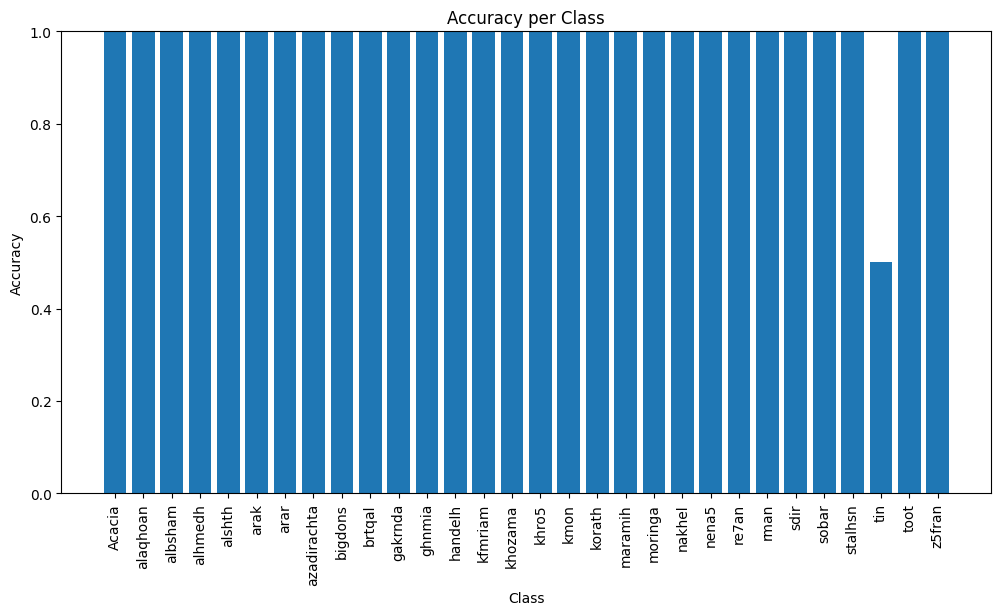

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# احصل على أسماء التصنيفات من بيانات التدريب
class_names = train_dataset.class_names

# احصل على التنبؤات
predictions = model_pretrained.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels.numpy(), axis=1)

# احسب الدقة لكل تصنيف
accuracy_per_class = {}
for class_index, class_name in enumerate(class_names):
    class_indices = np.where(true_classes == class_index)[0]
    class_correct = np.sum(predicted_classes[class_indices] == true_classes[class_indices])
    class_total = len(class_indices)
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    accuracy_per_class[class_name] = class_accuracy

# اعرض النتائج
accuracy_df = pd.DataFrame.from_dict(accuracy_per_class, orient='index', columns=['Accuracy'])
accuracy_df.index.name = 'Class'
print(accuracy_df)

# رسم الدقة لكل تصنيف
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df.index, accuracy_df['Accuracy'])
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.show()


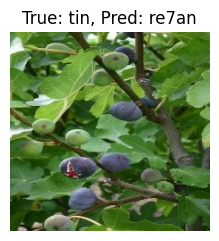

In [ ]:
# احصل على التنبؤات الخاطئة
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# عرض بعض الصور التي تم تصنيفها بشكل خاطئ
num_images_to_display = 10
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_images_to_display]):
    plt.subplot(5, 2, i + 1)
    plt.imshow(test_images[index].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_classes[index]]}, Pred: {class_names[predicted_classes[index]]}")
    plt.axis('off')
plt.show()
